**Challenge description**


The purpose of this project is creating a model of high precision and accuracy in detecting fraud of transactions made through mobile devices.

At the end of the project the CEO of Blocker Fraud Company will have a model in production capable of send transactions by API and it will classifies them as fraudulent or legitimate.

In addition, there is going to be a  report reporting  model's performance and results in relation to the profit and loss that the company will have when using the model you produced. The main subjects will contain the answers to the following questions:

    1- What is the Precision and Accuracy of the model?
    2- How Reliable is the model in classifying transactions as legitimate or fraudulent?
    3- What is the Expected Billing by the Company if we classify 100% of the transactions with the model?
    4- What is the Loss Expected by the Company in case of model failure?
    5- What is the Profit Expected by the Blocker Fraud Company when using the model?

# INTRODUCTION

## Data Dictionary

Source data set: https://www.kaggle.com/ntnu-testimon/paysim1

| Feature        | Description                                                                                                                                                                                                                                                                                           |
|:----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| step           | maps a unit of time in the real world\. In this case 1 step is 1 hour of time\. Total steps 744 \(30 days simulation\)\.                                                                                                                                                                              |
| type           | Transaction type \(CASH\-IN, CASH\-OUT, DEBIT, PAYMENT and TRANSFER\)                                                                                                                                                                                                                                 |
| amount         | amount of the transaction in local currency                                                                                                                                                                                                                                                           |
| nameOrig       | customer who started the transaction                                                                                                                                                                                                                                                                  |
| oldbalanceOrg  | initial balance before the transaction                                                                                                                                                                                                                                                                |
| newbalanceOrig | new balance after the transaction                                                                                                                                                                                                                                                                     |
| nameDest       | customer who is the recipient of the transaction                                                                                                                                                                                                                                                      |
| oldbalanceDest | initial balance recipient before the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                   |
| newbalanceDest | new balance recipient after the transaction\. Note that there is not information for customers that start with M \(Merchants\)                                                                                                                                                                        |
| isFraud        | This is the transactions made by the fraudulent agents inside the simulation\. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts\. An illegal attempt in this dataset is an attempt to transfer more than 200K in a single transaction                                                                                 |


## IMPORTS

In [1]:
# general libraries 
import math
import numpy  as np
import pandas as pd
import random as rd



#altering texts
import inflection

#creating and configuring graphics
import seaborn as sns
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


#data selection and algorithm  
import xgboost as xgb
from scipy                 import stats  as ss
from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


#others
import warnings
warnings.filterwarnings( 'ignore' )

#API 
from flask import Flask, request, Response

##  Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
    
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r,k = cm.shape
    chi2corr = max(0,chi2 - (((k-1)*(r-1))/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1) ) )
    return v


    
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')    
            end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df  


def ml_error(model_name,y,yhat):
    
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                          'RMSE':rmse},index=[0])

def mean_absolute_percentage_error(y, yhat):
   return np.mean( np.abs((y-yhat)/y))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


## Loading Data

In [3]:
df_raw = pd.read_csv('data/train.csv')

#  Data Description

In [4]:
df1 = df_raw.copy()

##  Rename Columns

In [5]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

In [6]:
snakecase = lambda x: inflection.underscore(x)

In [7]:
cols_new = list(map(snakecase,cols_old))

In [8]:
df1.columns = cols_new

##  Data Dimension and sample choice

In [9]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of columns {df1.shape[1]}')

Number of rows 6362620
Number of columns 11


The data Dimension is **6.362.620,00** rows and 11 columns, due hardware limitations, we will need to get a smaller sample from this data

In [10]:
perc = df1['is_fraud'][(df1['is_fraud']==1)].sum() /  df1['is_fraud'].count()
print('The fraud percentual is {}%'.format(perc*100))


The fraud percentual is 0.12908204481801522%


In [11]:
sample_df = df1.groupby('is_fraud').apply(lambda x: x.sample(frac=0.12908204481801522))
df1 = sample_df

In [12]:
perc = df1['is_fraud'][(df1['is_fraud']==1)].sum() /  df1['is_fraud'].count()
print(f'The new number of rows is {df1.shape[0]}')
print(f'The new number of columns {df1.shape[1]}')
print('The fraud percentual is {}%'.format(perc*100))


The new number of rows is 821300
The new number of columns 11
The fraud percentual is 0.12906367953244854%


## Data Type

In [13]:
df2 = df1.copy()

In [14]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

##  Check NA

In [15]:
#there isn't NA values

In [16]:
df2.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

##  Descriptive Statistics


In [17]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1['type']

###  Attributes

In [18]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.420000e+02,7.410000e+02,2.433225e+02,239.000,1.423744e+02,0.375193,0.328424
1,amount,0.0,6.278542e+07,6.278542e+07,1.788931e+05,74970.365,5.778366e+05,27.821060,1423.081239
2,oldbalance_org,0.0,5.039905e+07,5.039905e+07,8.361781e+05,14012.000,2.897620e+06,5.250351,33.000234
3,newbalance_orig,0.0,4.368662e+07,4.368662e+07,8.573095e+05,0.000,2.932820e+06,5.172782,31.973042
4,oldbalance_dest,0.0,3.553814e+08,3.553814e+08,1.098131e+06,132464.495,3.342246e+06,19.391194,940.619155
5,newbalance_dest,0.0,3.560159e+08,3.560159e+08,1.221257e+06,215451.775,3.590454e+06,18.447849,813.528883
6,is_fraud,0.0,1.000000e+00,1.000000e+00,1.290637e-03,0.000,3.590224e-02,27.781566,769.817307
7,is_flagged_fraud,0.0,1.000000e+00,1.000000e+00,6.087909e-06,0.000,2.467361e-03,405.287059,164255.999987


### Categorical attributes and variable filter 

In [20]:
cat_attributes = cat_attributes.drop_duplicates()
cat_attributes.head()

is_fraud         
0         1713620     CASH_IN
          3314541     PAYMENT
          2446199    CASH_OUT
          5754952    TRANSFER
          4568099       DEBIT
Name: type, dtype: object

In [21]:
a1 = df2['type'][(df2['type']=='PAYMENT') & (df2['is_fraud']==1)].count()
a2 = df2['type'][(df2['type']=='TRANSFER') & (df2['is_fraud']==1)].count()
a3 = df2['type'][(df2['type']=='CASH_OUT') & (df2['is_fraud']==1)].count()
a4 = df2['type'][(df2['type']=='DEBIT') & (df2['is_fraud']==1)].count()
a5 = df2['type'][(df2['type']=='CASH_IN') & (df2['is_fraud']==1)].count()
a6 = df2['type'][(df2['is_fraud']==1)].count()

In [22]:
print('Payment {}. Transfer {}. Cash_out {} . Debit {} . Cash_in {}. Total {}'.format(a1,a2,a3,a4,a5,a6) )

Payment 0. Transfer 530. Cash_out 530 . Debit 0 . Cash_in 0. Total 1060


### Deleting not useful types

There is not any fraud example in Payments, Cash_in and Debit, based on that, we will drop these types of transactions from the data frame

In [23]:
df2 = df2[(df2.type != 'PAYMENT') & (df2.type != 'DEBIT') & (df2.type != 'CASH_IN') ]

# Feature Engineering

In [24]:
#turning the sample into a csv file, so we can always use the same sample
#df2.to_csv(r'/home/leonardo/blocker_fraud_company/data/df_sample.csv')

In [25]:
df3 = pd.read_csv('/home/leonardo/blocker_fraud_company/data/df_sample.csv')

##  Mind map Hypotheses 

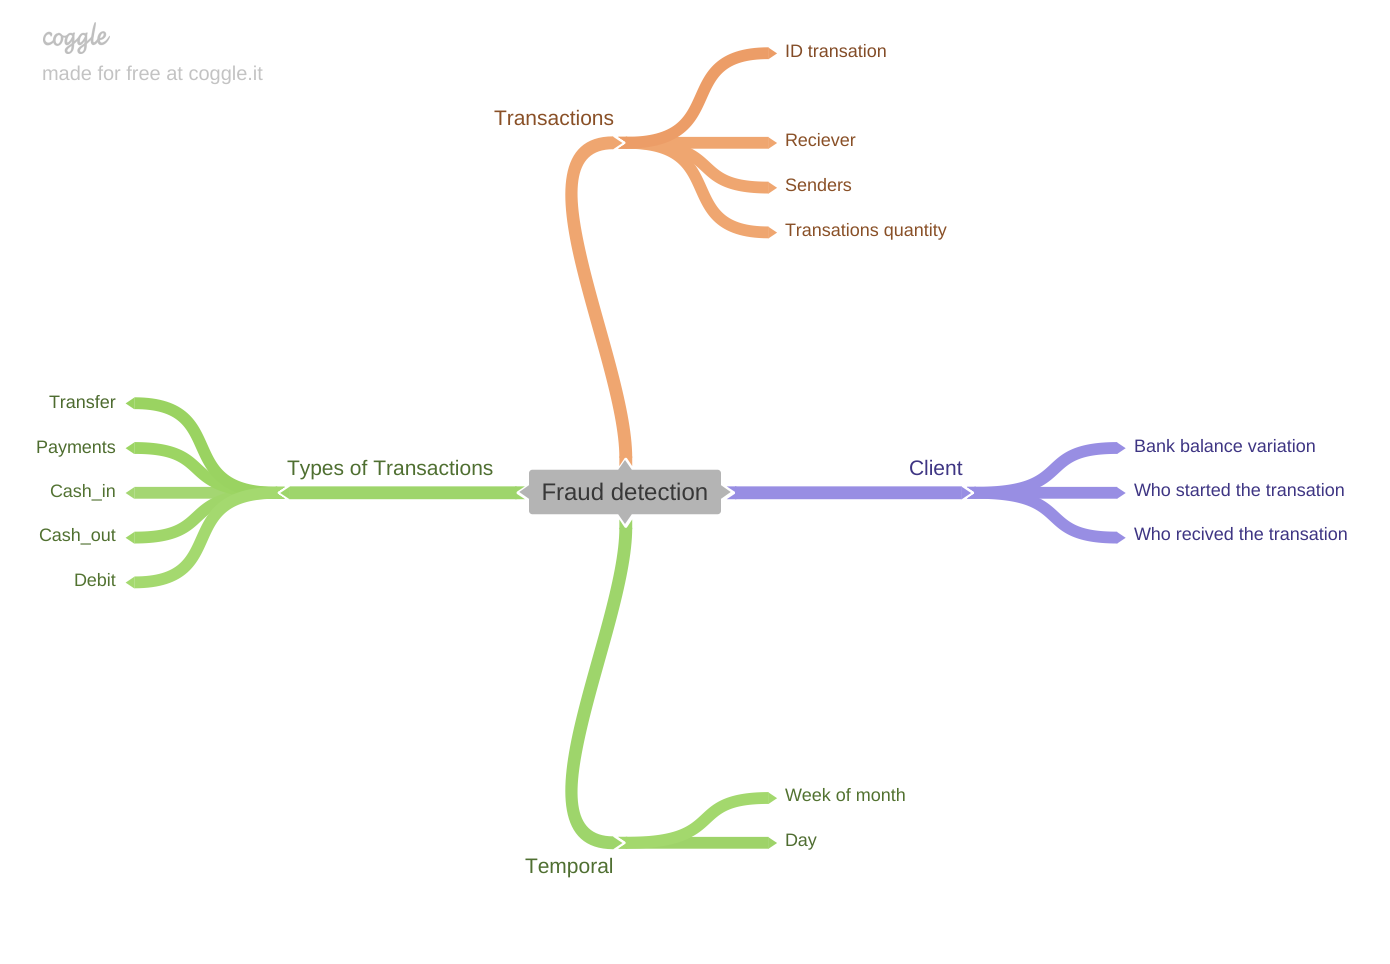

In [26]:
Image('img/Fraud_detection.png')

##  Hypothesis creation

### Type of transactions

In [27]:
#type of transactions already in the dataset 

### Temporal 

In [28]:
# week of month
df3['week_of_month'] = df3['step'].apply(lambda x: x/(24*7)  ).astype(int)
#day
df3['day_of_month'] = df3['step'].apply(lambda x: x/24).astype(int)


In [29]:
df3

,is_fraud,Unnamed: 1,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud.1,is_flagged_fraud,week_of_month,day_of_month
0,0,3807078,281,CASH_OUT,118035.33,C1458573557,0.00,0.0,C1011327941,323412.58,441447.92,0,0,1,11
1,0,2280345,187,CASH_OUT,108902.87,C1281506030,25372.00,0.0,C224713062,307213.63,416116.50,0,0,1,7
2,0,3817919,281,CASH_OUT,244173.70,C248730046,49537.00,0.0,C1876543998,0.00,244173.70,0,0,1,11
3,0,3977715,297,CASH_OUT,320636.56,C1490350516,0.00,0.0,C2098652030,4395126.25,4715762.80,0,0,1,12
4,0,2359639,190,CASH_OUT,406650.21,C1985972159,0.00,0.0,C2034144661,3860832.38,4267482.59,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357370,1,6360920,717,CASH_OUT,751854.42,C1391223821,751854.42,0.0,C450487671,11716.66,763571.08,1,0,4,29
357371,1,3273908,251,CASH_OUT,2693520.61,C1734542824,2693520.61,0.0,C1750548903,2505748.79,5199269.41,1,0,1,10
357372,1,4667,4,TRANSFER,169941.73,C540962910,169941.73,0.0,C2127862399,0.00,0.00,1,0,0,0
357373,1,6259987,608,TRANSFER,388171.95,C1413288238,388171.95,0.0,C1384608658,0.00,0.00,1,0,3,25


### Client Hypothesis

In [30]:
#bank balance variation
df3['balance_variation_dest'] = df3['oldbalance_dest'] - df3['newbalance_dest']
df3['balance_variation_org'] = df3['oldbalance_org'] - df3['newbalance_orig']

#who started the transaction: in case of future studies
# who received: in case of future studies

In [31]:
df3

,is_fraud,Unnamed: 1,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud.1,is_flagged_fraud,week_of_month,day_of_month,balance_variation_dest,balance_variation_org
0,0,3807078,281,CASH_OUT,118035.33,C1458573557,0.00,0.0,C1011327941,323412.58,441447.92,0,0,1,11,-118035.34,0.00
1,0,2280345,187,CASH_OUT,108902.87,C1281506030,25372.00,0.0,C224713062,307213.63,416116.50,0,0,1,7,-108902.87,25372.00
2,0,3817919,281,CASH_OUT,244173.70,C248730046,49537.00,0.0,C1876543998,0.00,244173.70,0,0,1,11,-244173.70,49537.00
3,0,3977715,297,CASH_OUT,320636.56,C1490350516,0.00,0.0,C2098652030,4395126.25,4715762.80,0,0,1,12,-320636.55,0.00
4,0,2359639,190,CASH_OUT,406650.21,C1985972159,0.00,0.0,C2034144661,3860832.38,4267482.59,0,0,1,7,-406650.21,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357370,1,6360920,717,CASH_OUT,751854.42,C1391223821,751854.42,0.0,C450487671,11716.66,763571.08,1,0,4,29,-751854.42,751854.42
357371,1,3273908,251,CASH_OUT,2693520.61,C1734542824,2693520.61,0.0,C1750548903,2505748.79,5199269.41,1,0,1,10,-2693520.62,2693520.61
357372,1,4667,4,TRANSFER,169941.73,C540962910,169941.73,0.0,C2127862399,0.00,0.00,1,0,0,0,0.00,169941.73
357373,1,6259987,608,TRANSFER,388171.95,C1413288238,388171.95,0.0,C1384608658,0.00,0.00,1,0,3,25,0.00,388171.95


### Transactions Hypothesis 

In [32]:
#amount of transactions (how many times a client made a transaction)

count_map = df3['name_dest'].value_counts().to_dict()
df3['amount_of_transactions']=df3['name_dest'].map(count_map)

In [33]:
df3.head()

,is_fraud,Unnamed: 1,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud.1,is_flagged_fraud,week_of_month,day_of_month,balance_variation_dest,balance_variation_org,amount_of_transactions
0,0,3807078,281,CASH_OUT,118035.33,C1458573557,0.0,0.0,C1011327941,323412.58,441447.92,0,0,1,11,-118035.34,0.0,4
1,0,2280345,187,CASH_OUT,108902.87,C1281506030,25372.0,0.0,C224713062,307213.63,416116.50,0,0,1,7,-108902.87,25372.0,1
2,0,3817919,281,CASH_OUT,244173.70,C248730046,49537.0,0.0,C1876543998,0.00,244173.70,0,0,1,11,-244173.70,49537.0,1
3,0,3977715,297,CASH_OUT,320636.56,C1490350516,0.0,0.0,C2098652030,4395126.25,4715762.80,0,0,1,12,-320636.55,0.0,8
4,0,2359639,190,CASH_OUT,406650.21,C1985972159,0.0,0.0,C2034144661,3860832.38,4267482.59,0,0,1,7,-406650.21,0.0,1


# EXPLORATORY DATA ANALYSIS

In [34]:
df4= df3.copy()

In [35]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Univariate analysis

### Numerical Variable

array([[<AxesSubplot:title={'center':'is_fraud'}>,
        <AxesSubplot:title={'center':'Unnamed: 1'}>,
        <AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>],
       [<AxesSubplot:title={'center':'oldbalance_org'}>,
        <AxesSubplot:title={'center':'newbalance_orig'}>,
        <AxesSubplot:title={'center':'oldbalance_dest'}>,
        <AxesSubplot:title={'center':'newbalance_dest'}>],
       [<AxesSubplot:title={'center':'is_fraud.1'}>,
        <AxesSubplot:title={'center':'is_flagged_fraud'}>,
        <AxesSubplot:title={'center':'week_of_month'}>,
        <AxesSubplot:title={'center':'day_of_month'}>],
       [<AxesSubplot:title={'center':'balance_variation_dest'}>,
        <AxesSubplot:title={'center':'balance_variation_org'}>,
        <AxesSubplot:title={'center':'amount_of_transactions'}>,
        <AxesSubplot:>]], dtype=object)

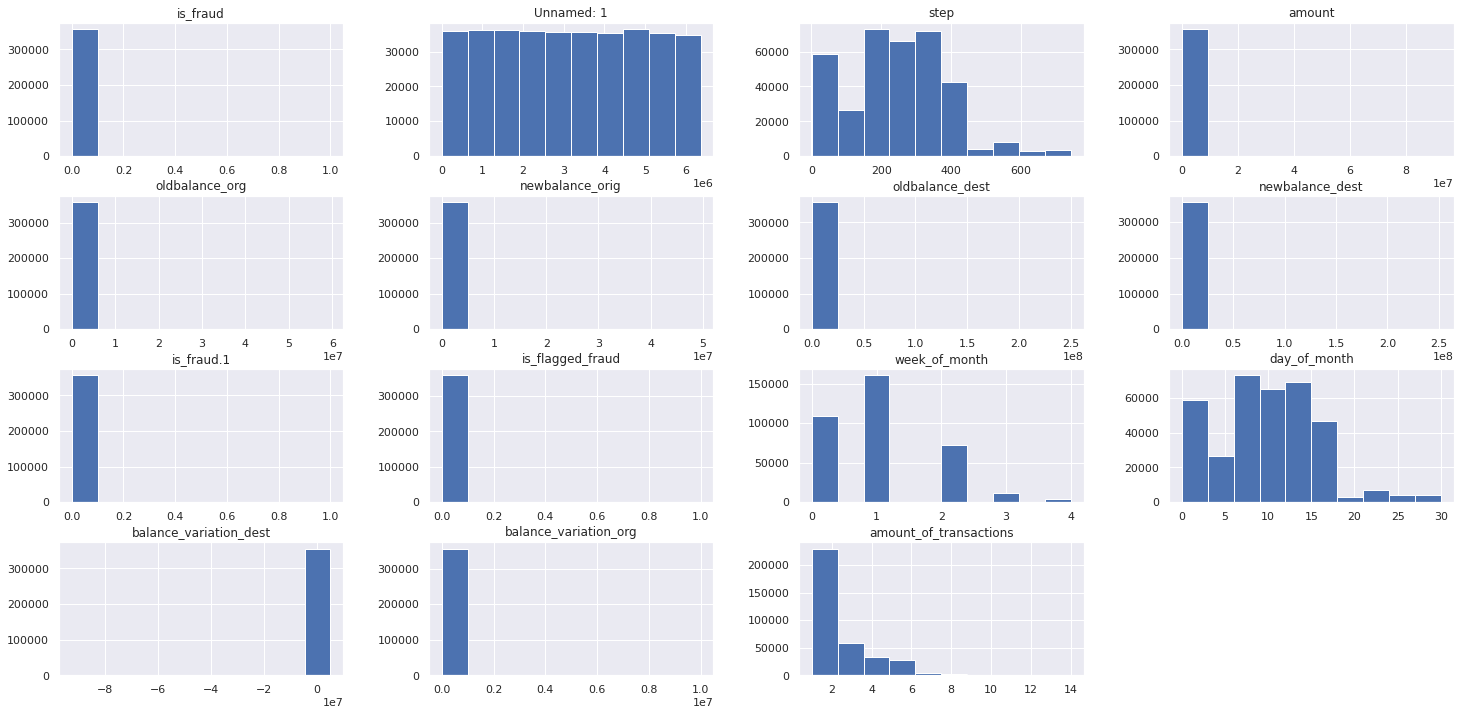

In [36]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist()

### Categorical Variables

<AxesSubplot:xlabel='amount', ylabel='Density'>

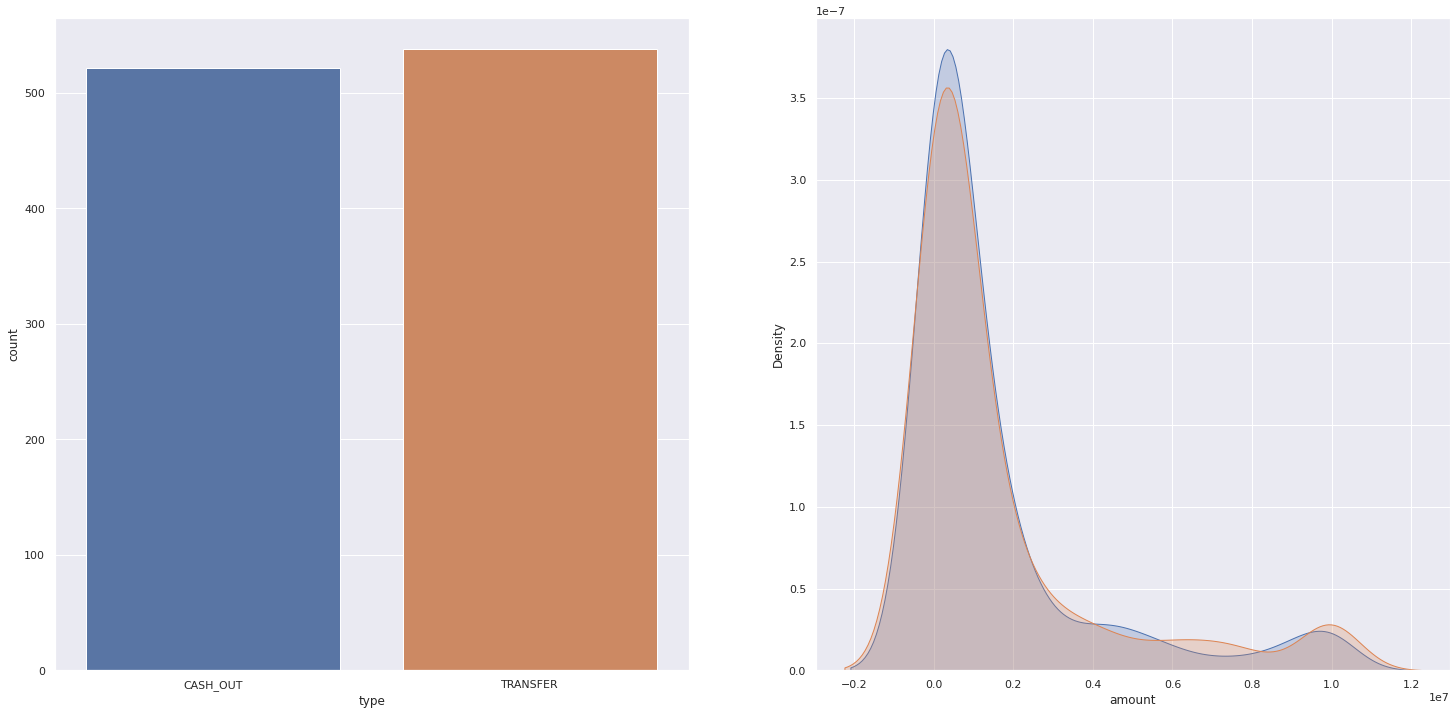

In [37]:
a = df4[(df4['is_fraud']==1)]
#types 
plt.subplot(1,2,1)
sns.countplot(a['type'])

plt.subplot(1,2,2)
sns.kdeplot(a[a['type'] =='CASH_OUT']['amount'],label='cash_out',shade=True)
sns.kdeplot(a[a['type'] =='TRANSFER']['amount'],label='transfer',shade=True)


## Bivariate analisys

 **1**- There is more fraud in the first and last week of month

**False** The last week is where there is the smaller amount of frauds

<AxesSubplot:xlabel='week_of_month', ylabel='is_fraud'>

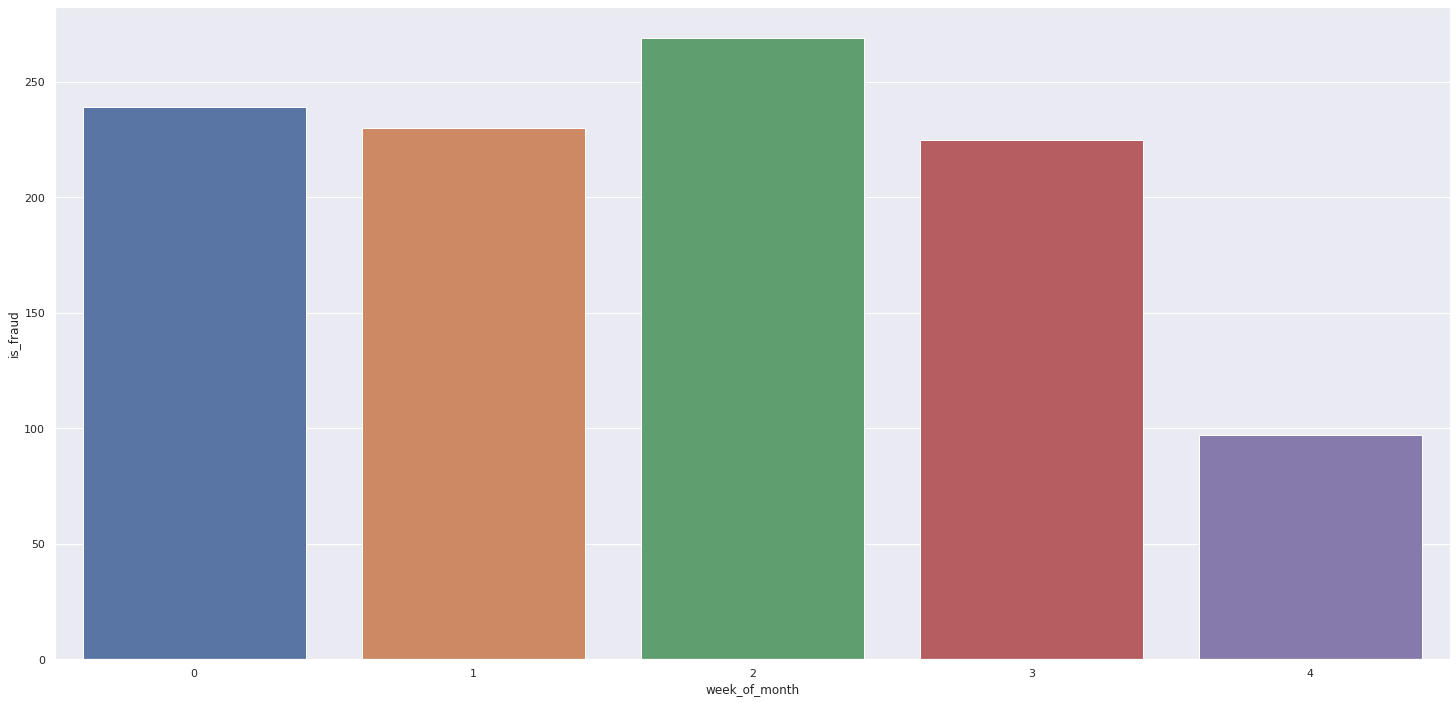

In [38]:
aux1 = df4[['week_of_month','is_fraud']].groupby('week_of_month').sum().reset_index()
sns.barplot(x='week_of_month',y='is_fraud',data=aux1)


**2**- There is more fraud in the first days of month

**True** There is more fraud in the first days of month

<AxesSubplot:xlabel='day_of_month', ylabel='Density'>

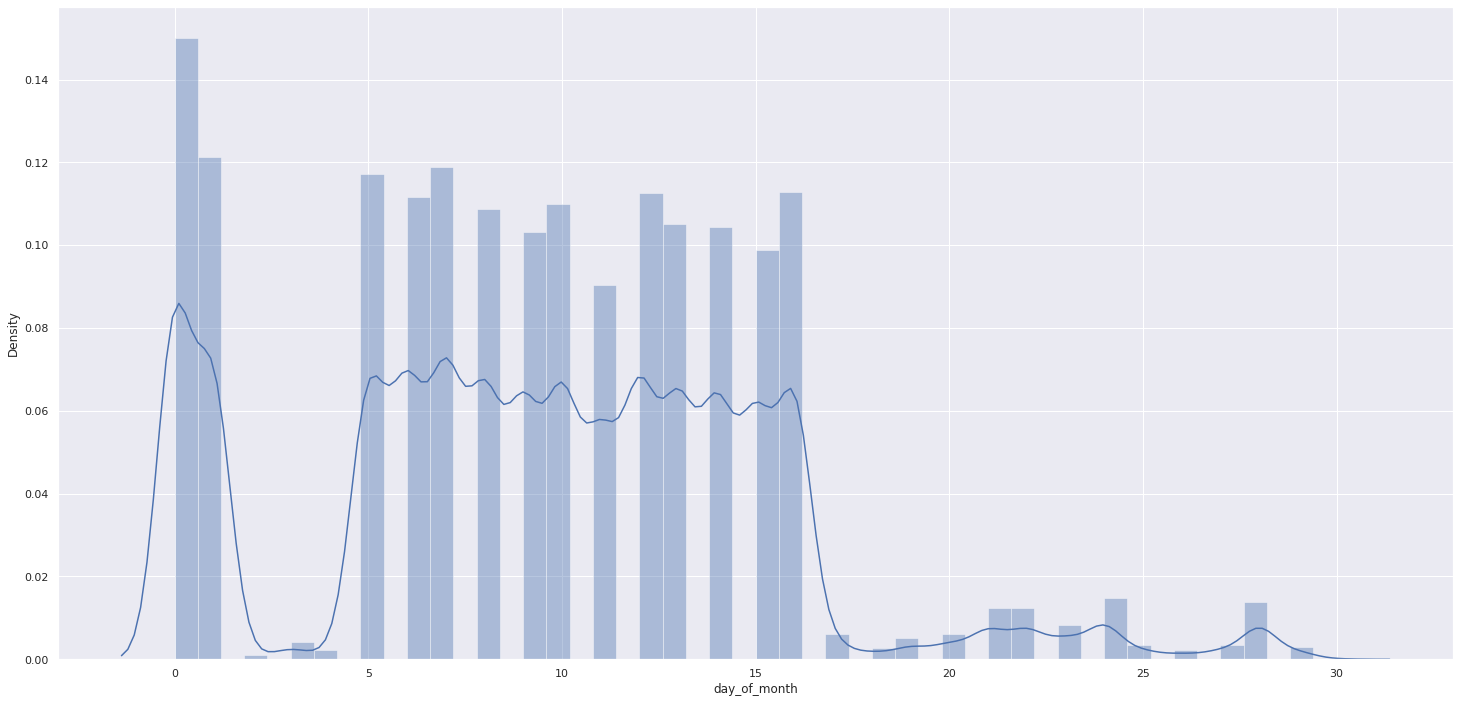

In [39]:
a = df4[(df4['is_fraud']==1)]
sns.distplot(df4['day_of_month'])


## Multivariate analysis

### Numerical attributes

<AxesSubplot:>

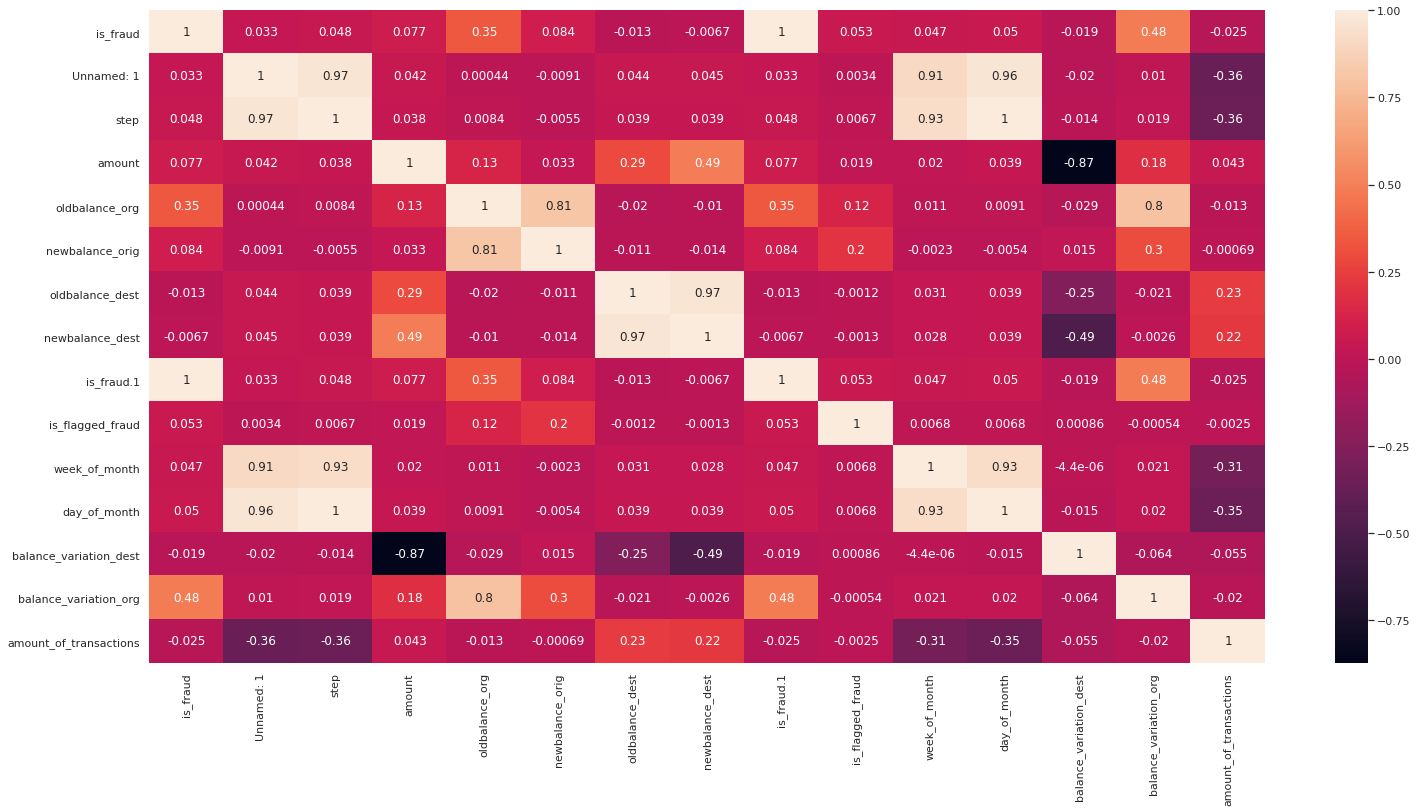

In [40]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True)

# Data Preparation

In [41]:
df5 = df4.copy()

## Rescaling

In [42]:
rs= RobustScaler()
mms = MinMaxScaler()

In [43]:
df5.describe()

,is_fraud,Unnamed: 1,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud.1,is_flagged_fraud,week_of_month,day_of_month,balance_variation_dest,balance_variation_org,amount_of_transactions
count,357375.000000,3.573750e+05,357375.000000,3.573750e+05,3.573750e+05,3.573750e+05,3.573750e+05,3.573750e+05,357375.000000,357375.000000,357375.000000,357375.000000,3.573750e+05,3.573750e+05,357375.000000
mean,0.002966,3.168326e+06,242.255605,3.169001e+05,4.837811e+04,1.649086e+04,1.694532e+06,2.039531e+06,0.002966,0.000008,0.996147,9.456095,-3.449993e+05,3.188725e+04,2.354773
std,0.054381,1.832512e+06,141.471712,8.865354e+05,2.805011e+05,1.767918e+05,4.038208e+06,4.479891e+06,0.054381,0.002897,0.857253,5.887300,1.168132e+06,1.710188e+05,1.543061
min,0.000000,3.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-9.244552e+07,0.000000e+00,1.000000
25%,0.000000,1.585018e+06,155.000000,8.297542e+04,0.000000e+00,0.000000e+00,1.277887e+05,3.271872e+05,0.000000,0.000000,0.000000,6.000000,-3.232355e+05,0.000000e+00,1.000000
50%,0.000000,3.159261e+06,237.000000,1.712999e+05,3.160000e+02,0.000000e+00,5.577336e+05,8.299742e+05,0.000000,0.000000,1.000000,9.000000,-1.753648e+05,3.060000e+02,2.000000
75%,0.000000,4.748060e+06,333.000000,3.069099e+05,3.105900e+04,0.000000e+00,1.733658e+06,2.116317e+06,0.000000,0.000000,1.000000,13.000000,-8.154086e+04,2.684994e+04,3.000000
max,1.000000,6.362616e+06,743.000000,9.244552e+07,5.958504e+07,4.958504e+07,2.498603e+08,2.519574e+08,1.000000,1.000000,4.000000,30.000000,5.233733e+06,1.000000e+07,14.000000
